In [3]:
import os
import splitfolders 
input_dir = os.path.join('flowers/')
output_dir = os.path.join('flowers_splitted/')
	
splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 4317 files [00:04, 909.30 files/s]


In [4]:
train_dir = os.path.join('flowers_splitted/train/')
test_dir = os.path.join('flowers_splitted/val/')

In [5]:
from keras.preprocessing.image import ImageDataGenerator

def image_generator(train_parent_directory, test_parent_directory):
		  
	train_datagen = ImageDataGenerator(rescale=1/255)
	test_datagen = ImageDataGenerator(rescale=1/255)
	    
	train_generator = train_datagen.flow_from_directory(train_parent_directory,
								target_size = (75,75),
	                            batch_size = 214,
	                            class_mode = 'categorical',
	                            subset='training')
	 
	    
	test_generator = test_datagen.flow_from_directory(test_parent_directory,
	                            target_size=(75,75),
	                            batch_size = 37,
	                            class_mode = 'categorical')    
	    
	return train_generator, test_generator

In [6]:
train_generator, test_generator = image_generator(train_dir, test_dir)

Found 3452 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [7]:
import tensorflow as tf

In [8]:
from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model = Sequential([
    Conv2D(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(units=5, activation='softmax')
])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 8)         6152      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 64)         

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:

history = model.fit(
    train_generator,
	steps_per_epoch=None,  
	epochs=100,
	verbose=1)

Epoch 1/100


17/17 [==============================] - 8s 400ms/step - loss: 1.5363 - accuracy: 0.3132
Epoch 2/100
17/17 [==============================] - 7s 393ms/step - loss: 1.3329 - accuracy: 0.4024
Epoch 3/100
17/17 [==============================] - 7s 396ms/step - loss: 1.2477 - accuracy: 0.4331
Epoch 4/100
17/17 [==============================] - 7s 415ms/step - loss: 1.2105 - accuracy: 0.4797
Epoch 5/100
17/17 [==============================] - 7s 396ms/step - loss: 1.1849 - accuracy: 0.5038
Epoch 6/100
17/17 [==============================] - 7s 404ms/step - loss: 1.2224 - accuracy: 0.4922
Epoch 7/100
17/17 [==============================] - 7s 398ms/step - loss: 1.1128 - accuracy: 0.5420
Epoch 8/100
17/17 [==============================] - 7s 395ms/step - loss: 1.0947 - accuracy: 0.5449
Epoch 9/100
17/17 [==============================] - 7s 398ms/step - loss: 1.0327 - accuracy: 0.5910
Epoch 10/100
17/17 [==============================] - 7s 393ms/step - loss: 1.0257 - accu

1/1 [==============================] - 0s 79ms/step
[[5.5800007e-11 1.0000000e+00 1.0381259e-10 6.8369538e-19 2.7448451e-13]]


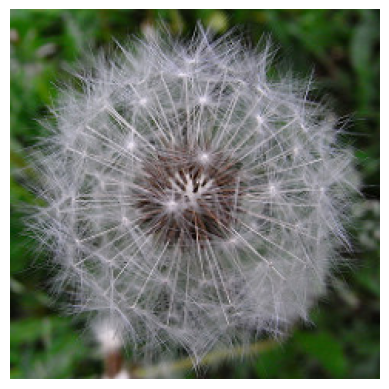

In [11]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

def import_and_predict(image_data, label):
    
    #read image
    img = cv2.imread(image_data)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    # resize and reshape the image
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    img_reshape = img_resize[np.newaxis,...]
    
    #predict the image
    prediction = model.predict(img_reshape)
    print(prediction)
    
    label_prediction = label[np.argmax(prediction)]
    
    return label_prediction
 
label = os.listdir(test_dir)
image1_dir = os.path.join(test_dir+'dandelion/3696596109_4c4419128a_m.jpg')

prediction = import_and_predict(image1_dir, label)

In [12]:
prediction

'dandelion'

1/1 [==============================] - 0s 21ms/step
[[9.3280794e-10 2.7709219e-12 9.3473645e-05 1.4508957e-11 9.9990654e-01]]


'tulip'

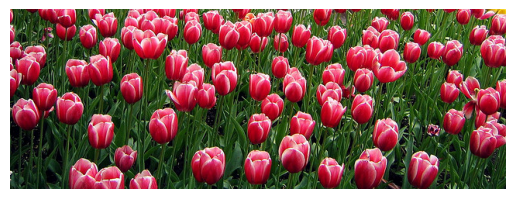

In [13]:
label = os.listdir(test_dir)
image2_dir = os.path.join(test_dir+'tulip/738207467_fc59cfcd9b_z.jpg')

prediction = import_and_predict(image2_dir, label)
prediction

In [14]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

In [15]:
from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

In [16]:

divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/3457

model_bayes = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(5), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(5)
    
])
model_bayes.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization   (None, 60, 60, 8)         12304     
 (Conv2DReparameterization)                                      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                      

C:\Users\amans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\amans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


 max_pooling2d_6 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_reparameterization (  (None, 5)                 5130      
 DenseRepa

In [17]:
from keras.optimizers import Adam

def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.005),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [18]:
history_bayes = model_bayes.fit(
      train_generator,
      epochs=300,
      verbose=1)

Epoch 1/300
17/17 [==============================] - 8s 391ms/step - loss: 8.0033 - accuracy: 0.1929
Epoch 2/300
17/17 [==============================] - 7s 393ms/step - loss: 7.7677 - accuracy: 0.2074
Epoch 3/300
17/17 [==============================] - 7s 392ms/step - loss: 7.5487 - accuracy: 0.2326
Epoch 4/300
17/17 [==============================] - 7s 390ms/step - loss: 7.5095 - accuracy: 0.1970
Epoch 5/300
17/17 [==============================] - 7s 390ms/step - loss: 7.2616 - accuracy: 0.2092
Epoch 6/300
17/17 [==============================] - 7s 386ms/step - loss: 7.0731 - accuracy: 0.2100
Epoch 7/300
17/17 [==============================] - 7s 390ms/step - loss: 6.8565 - accuracy: 0.2323
Epoch 8/300
17/17 [==============================] - 7s 392ms/step - loss: 6.6102 - accuracy: 0.2743
Epoch 9/300
17/17 [==============================] - 7s 387ms/step - loss: 6.4293 - accuracy: 0.2940
Epoch 10/300
17/17 [==============================] - 7s 394ms/step - loss: 6.2330 - accura

KeyboardInterrupt: 

In [ ]:
def import_and_predict_bayes(image, true_label):

    #read image
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    predicted_probabilities = np.empty(shape=(300, 5))
    
    for i in range(300):
        
        predicted_probabilities[i] = model_bayes(img_resize[np.newaxis,...]).mean().numpy()[0]
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(5)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(5)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar = ax.bar(np.arange(5), pct_97p5, color='red')
    bar[true_label].set_color('green')
    bar = ax.bar(np.arange(5), pct_2p5-0.02, color='white')
    ax.set_xticklabels([''] + [x for x in label])
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

C:\Users\amans\AppData\Local\Temp\ipykernel_7696\1929767446.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [x for x in label])


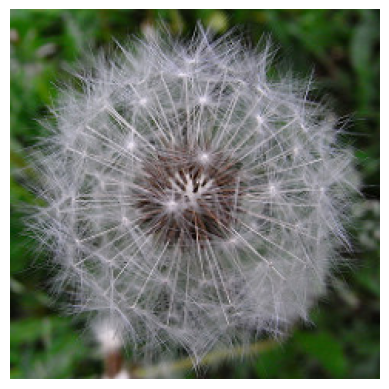

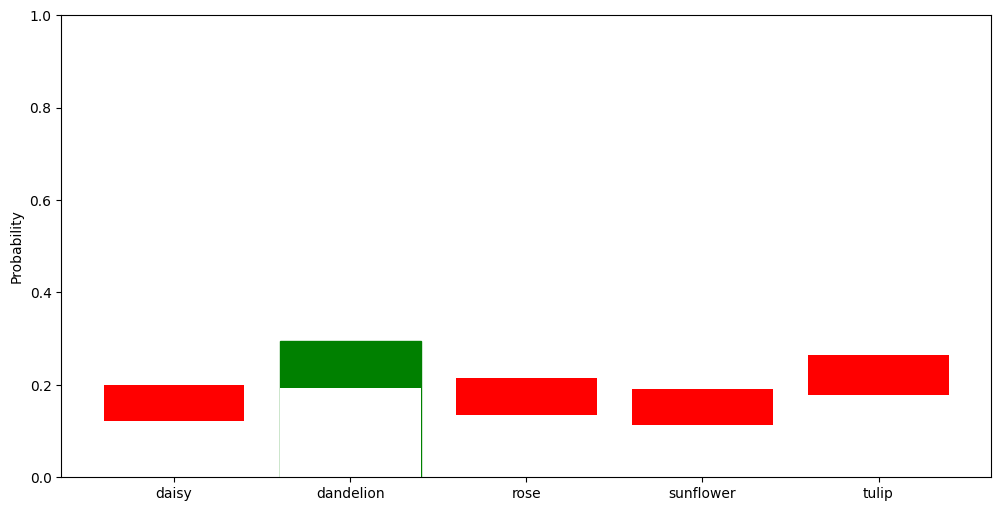

In [ ]:
import_and_predict_bayes(image1_dir, label.index('dandelion'))